In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core.base import Constraint as pyo_constraint
from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [2]:
def load_input_data(input_data):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_facilities = int(firstLine[0])
    num_customers = int(firstLine[1])
    
    data_dict = {}

    facility_cost_array = np.zeros(num_facilities)
    facility_capacity_array = np.zeros(num_facilities)
    facility_location_array = np.zeros((num_facilities, 2))
    for i in range(num_facilities):
        line = lines[i + 1]
        parts = line.split()
        facility_cost_array[i] = parts[0]
        facility_capacity_array[i] = parts[1]
        facility_location_array[i,:] = np.array([parts[2], parts[3]])
        
    data_dict['facility_cost_array'] = facility_cost_array
    data_dict['facility_capacity_array'] = facility_capacity_array
    data_dict['facility_location_array'] = facility_location_array

    customer_demand_array = np.zeros(num_customers)
    customer_location_array = np.zeros((num_customers, 2))
    for i in range(num_customers):
        line = lines[i + 1 + num_facilities]
        parts = line.split()
        customer_demand_array[i] = parts[0]
        customer_location_array[i,:] = np.array([parts[1], parts[2]])
        
    data_dict['customer_demand_array'] = customer_demand_array
    data_dict['customer_location_array'] = customer_location_array
    
    return data_dict

In [224]:
input_file = open('data/fl_1000_2','r').read()

In [225]:
data_dict = load_input_data(input_file)

In [5]:
data_dict

{'facility_cost_array': array([100., 100., 100.]),
 'facility_capacity_array': array([100., 100., 500.]),
 'facility_location_array': array([[1065., 1065.],
        [1062., 1062.],
        [   0.,    0.]]),
 'customer_demand_array': array([50., 50., 75., 75.]),
 'customer_location_array': array([[1397., 1397.],
        [1398., 1398.],
        [1399., 1399.],
        [ 586.,  586.]])}

In [21]:
def get_solution(data_dict, results_dict):
    
    solution = np.zeros(len(data_dict['customer_location_array']))
    for facility, customer_list in results_dict['facility_customers'].items():
        solution[customer_list] = facility
        
    return solution.astype(int)

In [22]:
solution = get_solution(data_dict, results_dict)
solution

array([0, 0, 1, 2])

In [7]:
def prepare_output_data(data_dict, results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    solution = get_solution(data_dict, results_dict)
    
    output_data = str(results_dict['objective_value']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution.astype(int)))
    
    return output_data

In [152]:
prepare_output_data(data_dict, results_dict, is_provably_optimal=False)

In [8]:
def create_facility_customer_dist_matrix(data_dict):
    
    """
    Distance matrix between facilities (rows) and customers (columns)
    """
    
    return cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])

In [9]:
facility_customer_dist_matrix = cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

### Write a greedy algorithm to solve

In [19]:
#def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    """
    Greedy algorithm. Simply finds the customer closest to any facility with enough
    capacity and assigns them to that facility, then moves to the next closest, etc. 
    """
    
    def get_k_smallest_indicies(arr, k):
        
        """Helper function"""
    
        flat_indices = np.argpartition(arr.ravel(), k-1)[:k]
        row_indices, col_indices = np.unravel_index(flat_indices, arr.shape)
        min_elements = arr[row_indices, col_indices]
        min_elements_order = np.argsort(min_elements)
        row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

        return [[row_indices[i], col_indices[i]] for i in range(len(col_indices))]
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix_copy = create_facility_customer_dist_matrix(data_dict)
    else:
        facility_customer_dist_matrix_copy = facility_customer_dist_matrix.copy()
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    customers_not_used = np.arange(num_customers)
    mins_to_choose_add = 5
    mins_to_choose = 5
    while len(customers_not_used) > 0:
        print(customers_not_used)
        customer_fits = False
        #facility_customer_dist_matrix_copy = facility_customer_dist_matrix_copy[:, customers_not_used]
        counter = 0
        while not customer_fits:
            if counter > mins_to_choose-1:
                mins_to_choose += mins_to_choose_add
            smallest_indicies = get_k_smallest_indicies(facility_customer_dist_matrix_copy[:, customers_not_used], 
                                                        min(mins_to_choose, 
                                                            facility_customer_dist_matrix_copy[:, customers_not_used].size-1))
            #print(smallest_indicies)
            #print(counter)
            #print(mins_to_choose)
            facility, customer = smallest_indicies[counter][0], smallest_indicies[counter][1]
            cost = facility_customer_dist_matrix_copy[:, customers_not_used][facility, customer]
            demand = customer_demand_array[customer]
            #print(cost)
            if facility_remaining_capacity[facility] >= demand:
                facility_remaining_capacity[facility] -= demand
                transport_costs += cost
                if facility not in facility_customers.keys():
                    facility_customers[facility] = [customer]
                    fixed_costs += facility_cost_array[facility]
                else:
                    facility_customers[facility].append(customer)
                customers_not_used = customers_not_used[customers_not_used!=customer]
                customer_fits = True
            else:
                counter += 1
            
    return facility_customers
            
            
        

In [26]:
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

In [182]:
def greedy_algorithm(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    
    customer_ordering = np.argsort(np.min(facility_customer_dist_matrix, axis=0))
    
    for customer in customer_ordering:
        closest_facility_indexes = np.argsort(facility_customer_dist_matrix[:, customer])
        customer_demand = customer_demand_array[customer]
        customer_allocated = False
        counter = 0
        #print('customer: ' + str(customer))
        #print('customer_demand: ' + str(customer_demand))
        while not customer_allocated:
            facility = closest_facility_indexes[counter]
            #print('facility: ' + str(facility))
            #print('facility capacity: ' +str(facility_remaining_capacity[facility]))
            if facility in facility_customers.keys():
                if facility_remaining_capacity[facility] >= customer_demand:
                    facility_customers[facility].append(customer)
                    facility_remaining_capacity[facility] -= customer_demand
                    transport_costs += facility_customer_dist_matrix[facility, customer]
                    customer_allocated = True
                    #print('used facility ' + str(facility))
                else:
                    counter += 1
            else:
                facility_customers[facility] = [customer]
                facility_remaining_capacity[facility] -= customer_demand
                fixed_costs += facility_cost_array[facility]
                transport_costs += facility_customer_dist_matrix[facility, customer]
                customer_allocated = True
                #print('used facility ' + str(facility))
        #print(' ')
        
    out_dict = {}
    out_dict['facility_customers'] = facility_customers
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = False
        
    return out_dict
                

In [183]:
greedy_results_dict = greedy_algorithm(data_dict)
greedy_results_dict

{'facility_customers': {0: [20, 87],
  34: [50, 23, 88, 6, 168, 122],
  30: [18],
  21: [192],
  41: [133, 72, 12, 147, 137, 171, 21, 48, 52],
  38: [40, 160, 28, 130, 139, 140],
  6: [101, 78, 75],
  13: [124, 109, 25, 194],
  2: [181, 44, 106, 170, 91],
  7: [90, 31, 164, 43],
  20: [33, 94, 157],
  40: [197, 174, 41, 97, 80],
  22: [19],
  47: [112, 183, 148, 134, 100, 176, 81],
  28: [121, 38, 184, 141, 36, 144],
  9: [37, 56, 22, 185, 143, 49, 138, 153, 69, 8, 27, 136, 24, 32, 189],
  11: [188, 129],
  39: [131, 102, 93, 73],
  29: [167, 152],
  15: [114, 5],
  24: [83, 29, 85, 1, 13, 86, 30, 96, 79, 115, 9],
  33: [179, 35],
  18: [53, 128],
  44: [105, 135, 178, 62, 51, 166, 198],
  14: [67, 58, 4],
  4: [65, 180],
  12: [71],
  10: [163, 169],
  46: [118, 74],
  5: [55, 125, 92, 161],
  25: [191, 47, 3, 39, 68, 117],
  42: [193, 146, 11],
  49: [14, 162, 155, 177],
  45: [154, 199],
  17: [175, 0, 145, 70],
  35: [61, 120, 77, 10, 150, 54, 59, 95, 172, 127, 123, 42, 113],
  27:

### Write and solve the optimisation model with Pyomo and CBC/CPLEX

In [11]:
def objective_function(model):
    
    return sum(model.fixed_costs[f] * model.x[f] for f in model.F) \
         + sum(sum(model.transport_costs[f, c] * model.y[f, c] for f in model.F) for c in model.C)

In [12]:
def constraint_open_facilities(model, f, c):
    
    return model.y[f, c] <= model.x[f]

def constraint_customer_assigned(model, c):
    
    return sum(model.y[f, c] for f in model.F) == 1

def constraint_capacity(model, f):
    
    return sum(model.demands[c] * model.y[f, c] for c in model.C) <= model.capacities[f]

In [13]:
def build_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in range(len(facility_cost_array))])
    model.C = pyo.Set(initialize=[c for c in range(len(customer_demand_array))])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={counter: element for counter, element in 
                                              enumerate(facility_cost_array)}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(counter_1, counter_2): facility_customer_dist_matrix[counter_1, counter_2] 
                                                  for counter_1 in range(len(facility_cost_array))
                                                  for counter_2 in range(len(customer_demand_array))}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={counter: element for counter, element in 
                                          enumerate(customer_demand_array)}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={counter: element for counter, element in 
                                             enumerate(facility_capacity_array)}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [14]:
def solve_model_milp(model, solver_name, solver_path, timeout_time=120, ratio_gap=0.01, show_working=True):
    
    print('Run start time: ' + str(ctime()))
    
    # Use CPLEX on the NEOS server
    if solver_name == 'cplex':
        manager = pyo.SolverManagerFactory('neos')
        opt_settings = SolverFactory(solver_name)
        opt_settings.set_options('mipgap=' + str(ratio_gap))
        opt_settings.set_options('timelimit=' + str(timeout_time))
        opt_settings.set_options('mipdisplay=' + str(3))
        opt_settings.set_options('nodefile=' + str(2))
        opt_settings.set_options('treememory=' + str(10000))
        results = manager.solve(model, opt=opt_settings, keepfiles=True)
        
    elif solver_name == 'cbc':
        opt_settings = SolverFactory(solver_name, executable=solver_path)
        opt_settings.set_options('sec=' + str(timeout_time))
        opt_settings.set_options('ratioGap=' + str(ratio_gap))
        results = opt_settings.solve(model, tee=show_working)
        
    else:
        raise ValueError(f'Solver {solver_name} not supported')
        
    print('Run finish time: ' + str(ctime()))        
    
    return model, results

In [127]:
model_instance = build_model(data_dict)

In [128]:
model_instance, results_instance = solve_model_milp(model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Wed Feb  5 14:06:43 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmptgsrnuf8.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmptgsrnuf8.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 10250 (-1) rows, 10050 (-1) columns and 40000 (-1) elements
Statistics for presolved model
Original problem has 10050 integers (10050 of which binary)
Presolved problem has 10050 integers (10050 of which binary)
==== 0 zero objective 10050 different
==== absolute objective values 10050 different
==== for integers 0 zero objective 10050 different
==== for integers absolute objective values 10050 different
===== end objective counts


Problem has 102

In [35]:
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=300, ratio_gap=0, show_working=True)

In [36]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [129]:
results_dict = get_results_dict(model_instance, results_instance, data_dict)
results_dict

{'facility_customers': {2: [44, 91, 106, 170, 181],
  3: [7, 15, 99, 186],
  4: [65, 180],
  5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  7: [31, 43, 90, 164],
  8: [27, 66, 76, 110, 126, 153, 196],
  9: [8, 22, 24, 32, 37, 49, 56, 64, 89, 108, 111, 136, 138, 143, 149, 185],
  10: [163, 169],
  11: [129, 188],
  13: [25, 109, 124, 172, 194],
  14: [4, 58, 67],
  15: [5, 114],
  16: [16, 103, 107, 119, 156, 182, 189],
  18: [53, 128],
  19: [2, 26, 45, 142],
  24: [1, 9, 13, 29, 30, 79, 83, 85, 86, 96, 115],
  25: [3, 33, 39, 47, 68, 94, 117, 157, 191],
  26: [17, 158],
  28: [0, 36, 38, 70, 121, 141, 144, 145, 175, 184],
  29: [152, 167],
  31: [34, 57, 60, 82, 84, 98, 104, 159, 173, 187, 190, 195],
  33: [35, 71, 179],
  34: [6, 23, 50, 88, 122, 168],
  35: [10, 42, 54, 59, 61, 77, 95, 113, 120, 123, 127, 150, 176],
  38: [28, 40, 130, 139, 140, 151, 160],
  39: [73, 93, 102, 131],
  40: [41, 46, 80, 97, 165, 174, 197],
  41: [12, 21, 48, 52, 72, 133, 137, 147, 171],
  42: [11, 7

In [38]:
solution = get_solution(data_dict, results_dict)
solution

array([28, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 43, 45, 45, 41,  9, 34,  9, 13, 19,  8, 38, 24, 24,  7,  9, 25,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 19, 40, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 31, 14, 35, 31, 35, 44, 43,  9,  4,  8, 14,
       25, 45, 28, 33, 41, 39, 42,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24, 45, 34,  9,  7,  2,  5, 39, 25, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  9, 13,  8,  9, 47, 35, 15, 24, 43, 25, 42,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 19,  9, 28, 28, 42, 41, 47,  9, 35, 38, 29,
        8, 45, 49, 16, 25, 26, 31, 38,  5, 49, 10,  7, 40, 44, 29, 34, 10,
        2, 41, 13, 31, 40, 28, 35, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11, 16, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [19]:
def get_objective_value_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    return transport_costs + fixed_costs

In [39]:
get_objective_value_from_solution(solution, data_dict)

3732793.43377155

In [24]:
def visualise_solution(data_dict, results_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Fixed cost: ' + str(int(results_dict['fixed_costs'])) \
                 + '   Transport costs: ' + str(int(results_dict['transport_costs'])))
    ax.scatter(customer_location_array[:, 0], customer_location_array[:, 1],  marker='+')
    ax.scatter(facility_location_array[:, 0], facility_location_array[:, 1],  marker='H')
    ax.axis('equal')
    
    for facility in range(len(facility_cost_array)):
        facility_location = facility_location_array[facility]
        if facility in results_dict['facility_customers']:
            for customer in results_dict['facility_customers'][facility]:
                customer_location = customer_location_array[customer]
                ax.annotate("",
                            xy=facility_location, xycoords='data',
                            xytext=customer_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


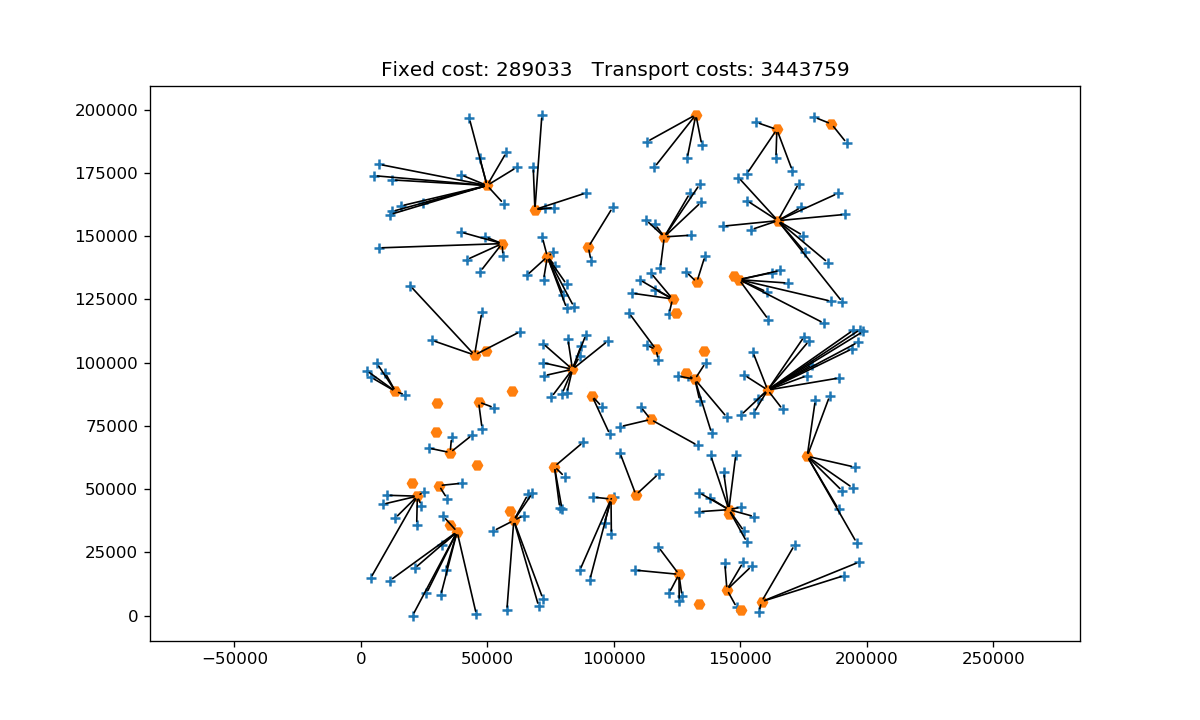

In [40]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

## Optimal

<IPython.core.display.Javascript object>


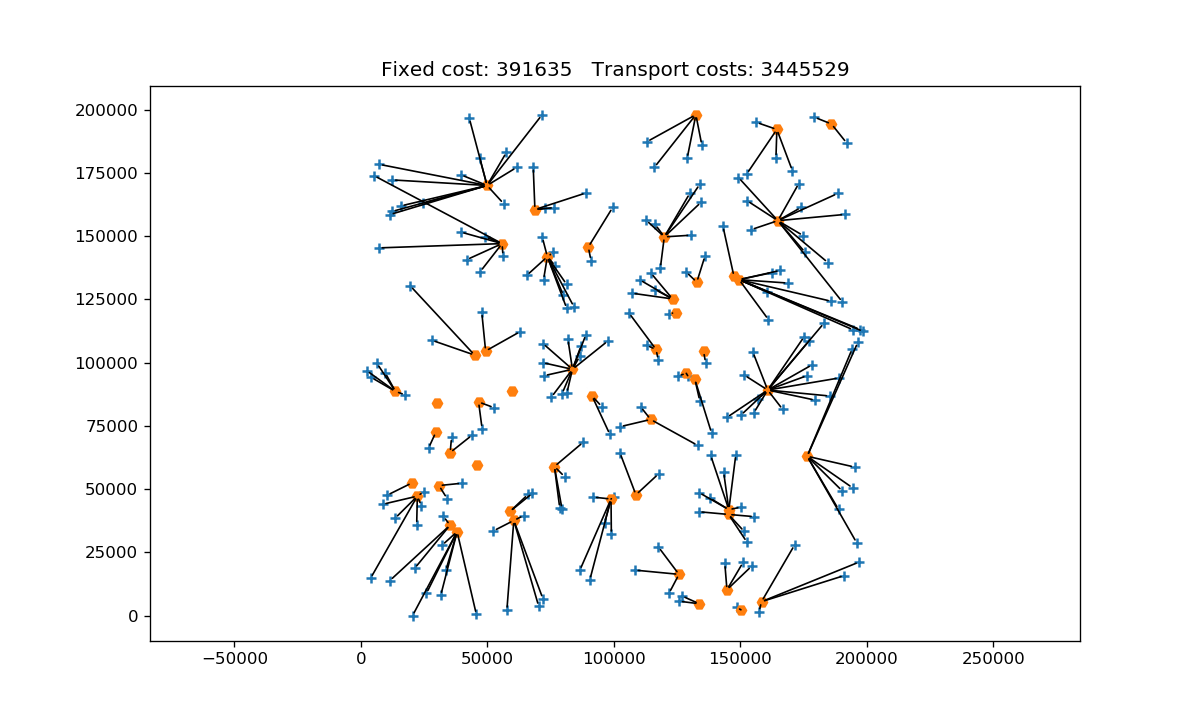

In [42]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

## Greedy

### Try a Large Neighbourhood Search algorithm

For a neighbourhood, pick a random part of the map (split it into a grid) and unassign all customers in the grid, as well as all facilities serving these customers and all customers served by those facilities. Solve this subproblem with a IP.

In [43]:
def get_customer_map_corners(customer_location_array):
    
    top_left = [customer_location_array[:,0].min(), customer_location_array[:,1].max()]
    bottom_left = [customer_location_array[:,0].min(), customer_location_array[:,1].min()]
    bottom_right = [customer_location_array[:,0].max(), customer_location_array[:,1].min()]
    top_right = [customer_location_array[:,0].max(), customer_location_array[:,1].max()]
    
    out_dict = {
        'top_left': top_left,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right,
        'top_right': top_right
    }
    
    return out_dict

In [44]:
map_corner_dict = get_customer_map_corners(data_dict['customer_location_array'])
map_corner_dict

{'top_left': [2332.1875, 197932.66],
 'bottom_left': [2332.1875, 0.0],
 'bottom_right': [198625.1425, 0.0],
 'top_right': [198625.1425, 197932.66]}

In [45]:
def interpolate(v1, v2, interp_points, n):
    
    if v1 > v2:
        return v2 + ((v1-v2)/interp_points)*n
    elif v2 > v1:
        return v1 + ((v2-v1)/interp_points)*n
    else:
        return v1

In [46]:
interpolate(10, 20, 10, 9)

19.0

In [47]:
def get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces,
                     central_width_piece_start_num, central_length_piece_start_num, 
                     width_piece_size = 1, length_piece_size = 1):
    
    width_additional_cells = (width_piece_size-1)/2
    length_additional_cells = (length_piece_size-1)/2
    
    x_left = interpolate(map_corner_dict['bottom_left'][0], 
                         map_corner_dict['bottom_right'][0], 
                         num_width_pieces, max(central_width_piece_start_num - width_additional_cells, 0))
    x_right = interpolate(map_corner_dict['bottom_left'][0], 
                          map_corner_dict['bottom_right'][0], 
                          num_width_pieces, min(central_width_piece_start_num + width_additional_cells + 1, 
                                               num_width_pieces))
    y_bottom = interpolate(map_corner_dict['bottom_left'][1], 
                           map_corner_dict['top_left'][1], 
                           num_length_pieces, max(central_length_piece_start_num - length_additional_cells, 0))
    y_top = interpolate(map_corner_dict['bottom_left'][1], 
                        map_corner_dict['top_left'][1], 
                        num_length_pieces, min(central_length_piece_start_num + length_additional_cells + 1, 
                                               num_length_pieces))
    
    out_dict = {
        'top_left': [x_left, y_top],
        'bottom_left': [x_left, y_bottom],
        'bottom_right': [x_right, y_bottom],
        'top_right': [x_right, y_top]
    }
    
    return out_dict

In [48]:
grid_corners = get_grid_corners(map_corner_dict, 10, 10, 5, 5 , width_piece_size = 3, length_piece_size = 3)
grid_corners

{'top_left': [80849.3695, 138552.862],
 'bottom_left': [80849.3695, 79173.064],
 'bottom_right': [139737.256, 79173.064],
 'top_right': [139737.256, 138552.862]}

In [49]:
def get_customers_in_grid(data_dict, grid_corners):
    
    customer_location_array  = data_dict['customer_location_array']
    
    customer_indexes = np.where((customer_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(customer_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(customer_location_array[:,1] <= grid_corners['top_left'][1])
                               &(customer_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return customer_indexes

In [50]:
get_customers_in_grid(data_dict, grid_corners)

array([  9,  19,  20,  29,  48,  52,  55,  62,  67,  75,  78,  79,  83,
        85,  86,  87,  92, 101, 114, 125, 154, 161, 167, 171, 192],
      dtype=int64)

In [51]:
def get_facilities_in_grid(data_dict, grid_corners):
    
    facility_location_array  = data_dict['facility_location_array']
    
    facility_indexes = np.where((facility_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(facility_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(facility_location_array[:,1] <= grid_corners['top_left'][1])
                               &(facility_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return facility_indexes

In [54]:
get_facilities_in_grid(data_dict, get_grid_corners(map_corner_dict, 10, 10, 5, 5, 3, 3))

array([ 0,  5,  6, 15, 21, 22, 24, 29, 45], dtype=int64)

In [59]:
def get_remaining_capacity_from_solution(data_dict, solution):
    
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    new_capacity_array = facility_capacity_array.copy()
    
    for idx in range(len(solution)):
        facility_index = solution[idx]
        new_capacity_array[facility_index] -= customer_demand_array[idx]
        
    return new_capacity_array

In [60]:
get_remaining_capacity_from_solution(data_dict, solution)

array([4765., 4800., 3596., 3311., 4066., 2666., 3997., 3194., 2715.,
         17., 4167., 4840., 3467., 3158., 3450., 3727., 2783., 5426.,
       3852., 5166., 5302., 4992., 4445., 4483., 1668., 1154., 3707.,
       5514.,  141., 4424., 4905., 1080., 5184., 4117., 3860.,   63.,
       4149., 5329., 1680., 3712., 2720., 2436., 2963., 3157., 2386.,
       3242., 4090., 3367., 5546., 3694.])

In [68]:
data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [101]:
#def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    new_facility_cost_array = np.zeros(len(facilities_to_include))
    new_facility_capacity_array = np.zeros(len(facilities_to_include))
    
    for counter in range(len(new_facility_cost_array)):
        facility = facilities_to_include[counter]
        new_facility_cost_array[counter] = data_dict['facility_cost_array'][facility]
        if facility in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][facility]
        else:
            new_facility_capacity_array[counter] = current_remaining_capacity_array[facility]
            
    new_customer_demand_array = np.array([demand for counter, demand in enumerate(data_dict['customer_demand_array'])
                                       if counter in customers_to_unassign])
    
    subproblem_data_dict = {
        'customers_to_unassign': customers_to_unassign,
        'facilities_to_unassign': facilities_to_unassign,
        'facilities_to_include': facilities_to_include,
        'facility_cost_array': new_facility_cost_array,
        'facility_capacity_array': new_facility_capacity_array,
        'customer_demand_array': new_customer_demand_array,
    }
    
    return subproblem_data_dict

In [107]:
#def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    subproblem_data_dict = data_dict.copy()
    
    new_facility_capacity_array = np.zeros(len(facilities_to_include))
    
    for counter in range(len(new_facility_capacity_array)):
        facility = facilities_to_include[counter]
        if facility in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][facility]
        else:
            new_facility_capacity_array[counter] = current_remaining_capacity_array[facility]
            
    subproblem_data_dict['new_facility_capacity_array'] = new_facility_capacity_array
    
    subproblem_data_dict['customers_to_unassign'] = customers_to_unassign
    subproblem_data_dict['facilities_to_include'] = facilities_to_include
    subproblem_data_dict['facilities_to_unassign'] = facilities_to_unassign

    
    return subproblem_data_dict

In [109]:
def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    subproblem_data_dict = data_dict.copy()
    
    new_facility_capacity_array = current_remaining_capacity_array.copy()
    
    for counter in range(len(current_remaining_capacity_array)):
        if counter in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][counter]
            
    subproblem_data_dict['new_facility_capacity_array'] = new_facility_capacity_array
    
    subproblem_data_dict['customers_to_unassign'] = customers_to_unassign
    subproblem_data_dict['facilities_to_include'] = facilities_to_include
    subproblem_data_dict['facilities_to_unassign'] = facilities_to_unassign

    
    return subproblem_data_dict

In [189]:
num_width_pieces = 4
num_length_pieces = 4
width_piece_num = 2
length_piece_num = 2

greedy_solution = get_solution(data_dict, greedy_results_dict)
solution = greedy_solution

map_corner_dict = get_customer_map_corners(data_dict['customer_location_array'])
grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                width_piece_num, length_piece_num , width_piece_size = 1, length_piece_size = 1)
initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
facilities_to_unassign = np.unique(solution[initial_customers_to_unassign])
customers_to_unassign = np.where(np.in1d(solution, facilities_to_unassign))[0]
wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                      width_piece_num, length_piece_num,
                                      width_piece_size = 3, length_piece_size = 3)
facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, solution)

In [140]:
initial_customers_to_unassign

array([  5,  19,  55,  62,  75,  78,  92, 101, 114, 125, 161, 192],
      dtype=int64)

In [141]:
facilities_to_unassign

array([ 5,  6, 15, 21, 22, 44])

In [142]:
facilities_to_include

array([ 0,  5,  6,  8,  9, 10, 11, 13, 14, 15, 16, 21, 22, 24, 29, 31, 37,
       39, 41, 44, 45, 47, 48, 49], dtype=int64)

In [79]:
data_dict['facility_cost_array']

array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
        8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
        9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
        8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
        7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
        8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
        8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
        6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
        7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
        9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278])

In [90]:
data_dict['facility_capacity_array'][facilities_to_include]

array([4765., 4800., 4924., 4775., 5099., 5699., 4522., 4471., 5190.,
       5426., 6794., 4992., 4445., 4483., 5686., 4562., 5514., 4065.,
       5043., 6218., 5329., 5023., 5728., 5431., 5652., 5779., 5546.])

In [85]:
np.sort(np.unique(solution))

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 24,
       25, 26, 28, 29, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47,
       49])

In [102]:
create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)

{'customers_to_unassign': array([  1,   4,   9,  13,  29,  30,  58,  67,  75,  78,  79,  83,  85,
         86,  96, 101, 115, 152, 167], dtype=int64),
 'facilities_to_unassign': array([ 6, 14, 24, 29]),
 'facilities_to_include': array([ 0,  1,  4,  5,  6, 11, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26, 27,
        28, 29, 34, 37, 39, 41, 44, 45, 47, 48], dtype=int64),
 'facility_cost_array': array([9730.3749, 7582.5512, 7591.9   , 8264.8269, 9295.8959, 8550.8948,
        8918.8834, 8585.5263, 8279.3467, 9233.8784, 6912.127 , 8726.1958,
        8463.1766, 8856.947 , 9532.9436, 9203.9761, 9903.5977, 9367.6393,
        9041.5207, 9422.5489, 7455.7327, 8898.1027, 6667.2292, 7043.196 ,
        9121.5227, 8300.9602, 9613.0121]),
 'facility_capacity_array': array([4765., 4800., 4066., 2666., 5099., 4840., 4522., 3727., 2783.,
        5426., 5166., 4992., 4445., 4483., 5686., 3707., 5514.,  141.,
        5043., 3860., 5329., 3712., 2436., 2386., 3242., 3367., 5546.]),
 'customer_demand_array': arr

In [108]:
create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [113]:
facilities_to_include

array([ 0,  1,  4,  5,  6, 11, 14, 15, 16, 17, 19, 21, 22, 23, 24, 26, 27,
       28, 29, 34, 37, 39, 41, 44, 45, 47, 48], dtype=int64)

In [114]:
facilities_to_unassign

array([ 6, 14, 24, 29])

In [143]:
subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)
subproblem_data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [116]:
def constraint_fix_open_facilities(model, f):
    
    return model.x[f] == 1

In [117]:
def build_subproblem_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    customers_to_unassign = data_dict['customers_to_unassign']
    facilities_to_unassign = data_dict['facilities_to_unassign']
    facilities_to_include  = data_dict['facilities_to_include']
    facility_cost_array = data_dict['facility_cost_array']
    new_facility_capacity_array = data_dict['new_facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in facilities_to_include])
    model.F_inc = pyo.Set(initialize=[f for f in facilities_to_include if f not in facilities_to_unassign])
    model.F_unas = pyo.Set(initialize=[f for f in facilities_to_unassign])
    model.C = pyo.Set(initialize=[c for c in customers_to_unassign])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={idx: facility_cost_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(facility, customer): facility_customer_dist_matrix[facility, customer] 
                                                  for facility in facilities_to_include
                                                  for customer in customers_to_unassign}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={idx: customer_demand_array[idx] for idx in 
                                          customers_to_unassign}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={idx: new_facility_capacity_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_set_open_facilities = pyo.Constraint(model.F_inc, rule=constraint_fix_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [144]:
subproblem_model_instance = build_subproblem_model(subproblem_data_dict, facility_customer_dist_matrix=None)

In [145]:
subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Wed Feb  5 14:16:57 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 150 (-343) rows, 438 (-19) columns and 1080 (-667) elements
Statistics for presolved model
Original problem has 456 integers (456 of which binary)
Presolved problem has 438 integers (438 of which binary)
==== 0 zero objective 438 different
==== absolute objective values 438 different
==== for integers 0 zero objective 438 different
==== for integers absolute objective values 438 different
===== end objective counts


Problem has 150 rows, 438 colum

In [ ]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [134]:
for tup, val in subproblem_model_instance.y.get_values().items():
    facility, customer = tup[0], tup[1]
    print(facility)
    print(customer)
    print(val)
    print(' ')

0
1
0.0
 
0
4
0.0
 
0
9
0.0
 
0
13
0.0
 
0
29
0.0
 
0
30
0.0
 
0
58
0.0
 
0
67
0.0
 
0
75
0.0
 
0
78
0.0
 
0
79
0.0
 
0
83
0.0
 
0
85
0.0
 
0
86
0.0
 
0
96
0.0
 
0
101
0.0
 
0
115
0.0
 
0
152
0.0
 
0
167
0.0
 
1
1
0.0
 
1
4
0.0
 
1
9
0.0
 
1
13
0.0
 
1
29
0.0
 
1
30
0.0
 
1
58
0.0
 
1
67
0.0
 
1
75
0.0
 
1
78
0.0
 
1
79
0.0
 
1
83
0.0
 
1
85
0.0
 
1
86
0.0
 
1
96
0.0
 
1
101
0.0
 
1
115
0.0
 
1
152
0.0
 
1
167
0.0
 
4
1
0.0
 
4
4
0.0
 
4
9
0.0
 
4
13
0.0
 
4
29
0.0
 
4
30
0.0
 
4
58
0.0
 
4
67
0.0
 
4
75
0.0
 
4
78
0.0
 
4
79
0.0
 
4
83
0.0
 
4
85
0.0
 
4
86
0.0
 
4
96
0.0
 
4
101
0.0
 
4
115
0.0
 
4
152
0.0
 
4
167
0.0
 
5
1
0.0
 
5
4
0.0
 
5
9
0.0
 
5
13
0.0
 
5
29
0.0
 
5
30
0.0
 
5
58
0.0
 
5
67
0.0
 
5
75
0.0
 
5
78
0.0
 
5
79
0.0
 
5
83
0.0
 
5
85
0.0
 
5
86
0.0
 
5
96
0.0
 
5
101
0.0
 
5
115
0.0
 
5
152
0.0
 
5
167
0.0
 
6
1
0.0
 
6
4
0.0
 
6
9
0.0
 
6
13
0.0
 
6
29
0.0
 
6
30
0.0
 
6
58
0.0
 
6
67
0.0
 
6
75
1.0
 
6
78
1.0
 
6
79
0.0
 
6
83
0.0
 
6
85
0.0
 
6
86
0.0
 
6
96
0.0


In [151]:
customers_to_unassign

18

In [146]:
subproblem_results_dict = get_results_dict(subproblem_model_instance, subproblem_results_instance, subproblem_data_dict)
subproblem_results_dict

{'facility_customers': {5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  15: [5, 114],
  44: [51, 62, 105, 135, 166, 178, 198],
  45: [19]},
 'fixed_costs': 42310.9678,
 'transport_costs': 212618.6772998851,
 'objective_value': 254929.64509988512,
 'is_optimal': True}

In [164]:
greedy_solution[192]

21

In [161]:
def repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict):
    
    new_solution = current_solution.copy()
    
    customer_to_facility_dict = {i: facility 
                                 for facility, customer_list in subproblem_results_dict['facility_customers'].items()
                                 for i in customer_list}
    
    for customer in subproblem_data_dict['customers_to_unassign']:
        new_solution[customer] = customer_to_facility_dict[customer]
        
    return new_solution

In [190]:
repair_solution(greedy_solution, subproblem_data_dict, subproblem_results_dict)

array([17, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 30, 45,  0, 41,  9, 34,  9, 13, 19,  9, 38, 24, 24,  7,  9, 20,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 23, 27, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 48, 14, 35, 31, 35, 44, 43,  8,  4,  8, 14,
       25,  9, 17, 12, 41, 39, 46,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24,  0, 34, 16,  7,  2,  5, 39, 20, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  8, 13,  8, 16, 47, 35, 15, 24, 43, 25, 46,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 23,  9, 28, 17, 42, 41, 47, 16, 35, 32, 29,
        9, 45, 49, 16, 20, 26, 31, 38,  5, 49, 10,  7, 27, 44, 29, 34, 10,
        2, 41, 35, 31, 40, 17, 47, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11,  9, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [160]:
d = {i: facility 
     for facility, customer_list in subproblem_results_dict['facility_customers'].items()
     for i in customer_list}
d

{55: 5,
 92: 5,
 125: 5,
 161: 5,
 192: 5,
 75: 6,
 78: 6,
 101: 6,
 5: 15,
 114: 15,
 51: 44,
 62: 44,
 105: 44,
 135: 44,
 166: 44,
 178: 44,
 198: 44,
 19: 45}

In [154]:
subproblem_data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [149]:
results_dict

{'facility_customers': {2: [44, 91, 106, 170, 181],
  3: [7, 15, 99, 186],
  4: [65, 180],
  5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  7: [31, 43, 90, 164],
  8: [27, 66, 76, 110, 126, 153, 196],
  9: [8, 22, 24, 32, 37, 49, 56, 64, 89, 108, 111, 136, 138, 143, 149, 185],
  10: [163, 169],
  11: [129, 188],
  13: [25, 109, 124, 172, 194],
  14: [4, 58, 67],
  15: [5, 114],
  16: [16, 103, 107, 119, 156, 182, 189],
  18: [53, 128],
  19: [2, 26, 45, 142],
  24: [1, 9, 13, 29, 30, 79, 83, 85, 86, 96, 115],
  25: [3, 33, 39, 47, 68, 94, 117, 157, 191],
  26: [17, 158],
  28: [0, 36, 38, 70, 121, 141, 144, 145, 175, 184],
  29: [152, 167],
  31: [34, 57, 60, 82, 84, 98, 104, 159, 173, 187, 190, 195],
  33: [35, 71, 179],
  34: [6, 23, 50, 88, 122, 168],
  35: [10, 42, 54, 59, 61, 77, 95, 113, 120, 123, 127, 150, 176],
  38: [28, 40, 130, 139, 140, 151, 160],
  39: [73, 93, 102, 131],
  40: [41, 46, 80, 97, 165, 174, 197],
  41: [12, 21, 48, 52, 72, 133, 137, 147, 171],
  42: [11, 7

In [147]:
greedy_results_dict

{'facility_customers': {0: [20, 87],
  34: [50, 23, 88, 6, 168, 122],
  30: [18],
  21: [192],
  41: [133, 72, 12, 147, 137, 171, 21, 48, 52],
  38: [40, 160, 28, 130, 139, 140],
  6: [101, 78, 75],
  13: [124, 109, 25, 194],
  2: [181, 44, 106, 170, 91],
  7: [90, 31, 164, 43],
  20: [33, 94, 157],
  40: [197, 174, 41, 97, 80],
  22: [19],
  47: [112, 183, 148, 134, 100, 176, 81],
  28: [121, 38, 184, 141, 36, 144],
  9: [37, 56, 22, 185, 143, 49, 138, 153, 69, 8, 27, 136, 24, 32, 189],
  11: [188, 129],
  39: [131, 102, 93, 73],
  29: [167, 152],
  15: [114, 5],
  24: [83, 29, 85, 1, 13, 86, 30, 96, 79, 115, 9],
  33: [179, 35],
  18: [53, 128],
  44: [105, 135, 178, 62, 51, 166, 198],
  14: [67, 58, 4],
  4: [65, 180],
  12: [71],
  10: [163, 169],
  46: [118, 74],
  5: [55, 125, 92, 161],
  25: [191, 47, 3, 39, 68, 117],
  42: [193, 146, 11],
  49: [14, 162, 155, 177],
  45: [154, 199],
  17: [175, 0, 145, 70],
  35: [61, 120, 77, 10, 150, 54, 59, 95, 172, 127, 123, 42, 113],
  27:

In [230]:
lns_parameter_dict = {
    'num_width_pieces': 10, 
    'num_length_pieces': 10,
    'iterations': 200
}

In [218]:
[(i, j) for i in range(5) for j in range(5)]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [222]:
def run_lns(data_dict, lns_parameter_dict, initial_sweep = True, initial_solution = None, pprint=False):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        #print('ytho')
        initial_solution_results_dict = greedy_algorithm(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
        
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, best_solution)
    
    if pprint:
        print('starting objective: ' + str(best_objective))
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    if initial_sweep:
        initial_sweep_list = [(i, j) for i in range(num_width_pieces) for j in range(num_length_pieces)]
        iterations = max(iterations, num_width_pieces*num_length_pieces)
    
    for iteration in range(iterations):
        if pprint:
            print('iteration ' + str(iteration))
        if initial_sweep and iteration < num_width_pieces*num_length_pieces:
            # if we're doing an initial sweet first use those values
            width_piece_num, length_piece_num = initial_sweep_list[iteration][0], initial_sweep_list[iteration][1]
        else:
            # pick a random square on the grid to optimise
            width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        if pprint:
            print((width_piece_num, length_piece_num))
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 3, length_piece_size = 3)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned, then create a new data 
        # dict for the subproblem
        current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, current_solution)
        subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                                           facilities_to_include, current_remaining_capacity_array)
        #if pprint:
        #    print(subproblem_data_dict)
        subproblem_model_instance = build_subproblem_model(subproblem_data_dict, 
                                                           facility_customer_dist_matrix=facility_customer_dist_matrix)
        subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=False)
        subproblem_results_dict = get_results_dict(subproblem_model_instance, 
                                                   subproblem_results_instance, 
                                                   subproblem_data_dict)
        #if pprint:
        #    print(subproblem_data_dict)
        new_solution = repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict)
        new_objective = get_objective_value_from_solution(new_solution, data_dict)
        if pprint:
            print('new objective_value: ' + str(new_objective))
        if new_objective < current_objective:
            current_solution = new_solution
            current_objective = new_objective
            if new_objective < best_objective:
                best_solution = new_solution
                best_objective = new_objective
                print('best objective updated')
        if pprint:
            print(' ')
            
    out_dict = {
        'solution_array': best_solution,
        'objective_value': best_objective
    }
                
    return out_dict
        
        

In [233]:
def run_lns(data_dict, lns_parameter_dict, initial_sweep = True, initial_solution = None, pprint=False):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        #print('ytho')
        initial_solution_results_dict = greedy_algorithm(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
        
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, best_solution)
    
    if pprint:
        print('starting objective: ' + str(best_objective))
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    if initial_sweep:
        initial_sweep_list = [(i, j) for i in range(num_width_pieces) for j in range(num_length_pieces)]
        iterations = max(iterations, num_width_pieces*num_length_pieces)
    
    iteration = 0
    while best_objective > 10000000:
        if pprint:
            print('iteration ' + str(iteration))
        if initial_sweep and iteration < num_width_pieces*num_length_pieces:
            # if we're doing an initial sweet first use those values
            width_piece_num, length_piece_num = initial_sweep_list[iteration][0], initial_sweep_list[iteration][1]
        else:
            # pick a random square on the grid to optimise
            width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        if pprint:
            print((width_piece_num, length_piece_num))
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 3, length_piece_size = 3)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned, then create a new data 
        # dict for the subproblem
        current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, current_solution)
        subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                                           facilities_to_include, current_remaining_capacity_array)
        #if pprint:
        #    print(subproblem_data_dict)
        subproblem_model_instance = build_subproblem_model(subproblem_data_dict, 
                                                           facility_customer_dist_matrix=facility_customer_dist_matrix)
        subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=False)
        subproblem_results_dict = get_results_dict(subproblem_model_instance, 
                                                   subproblem_results_instance, 
                                                   subproblem_data_dict)
        #if pprint:
        #    print(subproblem_data_dict)
        new_solution = repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict)
        new_objective = get_objective_value_from_solution(new_solution, data_dict)
        if pprint:
            print('new objective_value: ' + str(new_objective))
        if new_objective < current_objective:
            current_solution = new_solution
            current_objective = new_objective
            if new_objective < best_objective:
                best_solution = new_solution
                best_objective = new_objective
                print('best objective updated')
        if pprint:
            print(' ')
        iteration += 1
            
    out_dict = {
        'solution_array': best_solution,
        'objective_value': best_objective
    }
                
    return out_dict
        
        

In [229]:
lns_dict = run_lns(data_dict, lns_parameter_dict, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 10798061.75132535
iteration 0
(0, 0)
Run start time: Wed Feb  5 17:40:43 2020
Run finish time: Wed Feb  5 17:40:44 2020
new objective_value: 10784955.703641389
best objective updated
 
iteration 1
(0, 1)
Run start time: Wed Feb  5 17:40:44 2020
Run finish time: Wed Feb  5 17:40:44 2020
new objective_value: 10750982.989453826
best objective updated
 
iteration 2
(0, 2)
Run start time: Wed Feb  5 17:40:44 2020
Run finish time: Wed Feb  5 17:40:44 2020
new objective_value: 10741711.599357212
best objective updated
 
iteration 3
(0, 3)
Run start time: Wed Feb  5 17:40:44 2020
Run finish time: Wed Feb  5 17:40:45 2020
new objective_value: 10728180.648936393
best objective updated
 
iteration 4
(0, 4)
Run start time: Wed Feb  5 17:40:45 2020
Run finish time: Wed Feb  5 17:40:45 2020
new objective_value: 10710965.294407608
best objective updated
 
iteration 5
(0, 5)
Run start time: Wed Feb  5 17:40:45 2020
Run finish time: Wed Feb  5 17:40:46 2020
new objective_value: 1070

Run finish time: Wed Feb  5 17:41:10 2020
new objective_value: 10464311.871525135
 
iteration 53
(5, 3)
Run start time: Wed Feb  5 17:41:10 2020
Run finish time: Wed Feb  5 17:41:11 2020
new objective_value: 10453842.128089417
best objective updated
 
iteration 54
(5, 4)
Run start time: Wed Feb  5 17:41:11 2020
Run finish time: Wed Feb  5 17:41:11 2020
new objective_value: 10450438.519786967
best objective updated
 
iteration 55
(5, 5)
Run start time: Wed Feb  5 17:41:11 2020
Run finish time: Wed Feb  5 17:41:12 2020
new objective_value: 10462265.98758218
 
iteration 56
(5, 6)
Run start time: Wed Feb  5 17:41:12 2020
Run finish time: Wed Feb  5 17:41:13 2020
new objective_value: 10437977.934809249
best objective updated
 
iteration 57
(5, 7)
Run start time: Wed Feb  5 17:41:13 2020
Run finish time: Wed Feb  5 17:41:13 2020
new objective_value: 10423093.353868814
best objective updated
 
iteration 58
(5, 8)
Run start time: Wed Feb  5 17:41:14 2020
Run finish time: Wed Feb  5 17:41:14 20

Run finish time: Wed Feb  5 17:41:34 2020
new objective_value: 10086058.419841737
 
iteration 105
(2, 3)
Run start time: Wed Feb  5 17:41:34 2020
Run finish time: Wed Feb  5 17:41:35 2020
new objective_value: 10082330.995786179
best objective updated
 
iteration 106
(1, 0)
Run start time: Wed Feb  5 17:41:35 2020
Run finish time: Wed Feb  5 17:41:36 2020
new objective_value: 10087960.654220205
 
iteration 107
(5, 5)
Run start time: Wed Feb  5 17:41:36 2020
Run finish time: Wed Feb  5 17:41:36 2020
new objective_value: 10099795.273753058
 
iteration 108
(4, 1)
Run start time: Wed Feb  5 17:41:36 2020
Run finish time: Wed Feb  5 17:41:37 2020
new objective_value: 10107027.664581656
 
iteration 109
(8, 6)
Run start time: Wed Feb  5 17:41:37 2020
Run finish time: Wed Feb  5 17:41:37 2020
new objective_value: 10097754.620709864
 
iteration 110
(4, 5)
Run start time: Wed Feb  5 17:41:37 2020
Run finish time: Wed Feb  5 17:41:38 2020
new objective_value: 10117163.818387456
 
iteration 111
(0,

Run finish time: Wed Feb  5 17:42:01 2020
new objective_value: 10061395.363938008
 
iteration 160
(6, 8)
Run start time: Wed Feb  5 17:42:01 2020
Run finish time: Wed Feb  5 17:42:01 2020
new objective_value: 10090189.460559212
 
iteration 161
(2, 0)
Run start time: Wed Feb  5 17:42:02 2020
Run finish time: Wed Feb  5 17:42:02 2020
new objective_value: 10069185.48829411
 
iteration 162
(7, 9)
Run start time: Wed Feb  5 17:42:02 2020
Run finish time: Wed Feb  5 17:42:02 2020
new objective_value: 10061812.351651773
 
iteration 163
(3, 0)
Run start time: Wed Feb  5 17:42:03 2020
Run finish time: Wed Feb  5 17:42:03 2020
new objective_value: 10071902.42832098
 
iteration 164
(1, 7)
Run start time: Wed Feb  5 17:42:03 2020
Run finish time: Wed Feb  5 17:42:03 2020
new objective_value: 10061834.221665986
 
iteration 165
(2, 4)
Run start time: Wed Feb  5 17:42:03 2020
Run finish time: Wed Feb  5 17:42:04 2020
new objective_value: 10050173.19971564
best objective updated
 
iteration 166
(5, 8)

{'solution_array': array([897, 110, 872, ...,  28, 241, 128]),
 'objective_value': 10037358.588075377}

In [234]:
lns_dict = run_lns(data_dict, lns_parameter_dict, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 10798061.75132535
iteration 0
(0, 0)
Run start time: Wed Feb  5 17:46:07 2020
Run finish time: Wed Feb  5 17:46:08 2020
new objective_value: 10783587.121623054
best objective updated
 
iteration 1
(0, 1)
Run start time: Wed Feb  5 17:46:08 2020
Run finish time: Wed Feb  5 17:46:08 2020
new objective_value: 10775082.081179455
best objective updated
 
iteration 2
(0, 2)
Run start time: Wed Feb  5 17:46:08 2020
Run finish time: Wed Feb  5 17:46:09 2020
new objective_value: 10765198.090609241
best objective updated
 
iteration 3
(0, 3)
Run start time: Wed Feb  5 17:46:09 2020
Run finish time: Wed Feb  5 17:46:09 2020
new objective_value: 10735924.83139006
best objective updated
 
iteration 4
(0, 4)
Run start time: Wed Feb  5 17:46:09 2020
Run finish time: Wed Feb  5 17:46:10 2020
new objective_value: 10722185.392750347
best objective updated
 
iteration 5
(0, 5)
Run start time: Wed Feb  5 17:46:10 2020
Run finish time: Wed Feb  5 17:46:10 2020
new objective_value: 10720

Run start time: Wed Feb  5 17:46:40 2020
Run finish time: Wed Feb  5 17:46:40 2020
new objective_value: 10397615.469892692
best objective updated
 
iteration 52
(5, 7)
Run start time: Wed Feb  5 17:46:41 2020
Run finish time: Wed Feb  5 17:46:41 2020
new objective_value: 10374400.757346455
best objective updated
 
iteration 53
(5, 8)
Run start time: Wed Feb  5 17:46:41 2020
Run finish time: Wed Feb  5 17:46:42 2020
new objective_value: 10366023.351761963
best objective updated
 
iteration 54
(6, 0)
Run start time: Wed Feb  5 17:46:42 2020
Run finish time: Wed Feb  5 17:46:42 2020
new objective_value: 10370349.385044027
 
iteration 55
(6, 1)
Run start time: Wed Feb  5 17:46:42 2020
Run finish time: Wed Feb  5 17:46:43 2020
new objective_value: 10366459.557769697
 
iteration 56
(6, 2)
Run start time: Wed Feb  5 17:46:43 2020
Run finish time: Wed Feb  5 17:46:43 2020
new objective_value: 10361686.169840224
best objective updated
 
iteration 57
(6, 3)
Run start time: Wed Feb  5 17:46:43 20

Run start time: Wed Feb  5 17:47:12 2020
Run finish time: Wed Feb  5 17:47:13 2020
new objective_value: 10120756.550982878
best objective updated
 
iteration 105
(5, 7)
Run start time: Wed Feb  5 17:47:13 2020
Run finish time: Wed Feb  5 17:47:13 2020
new objective_value: 10144144.590413023
 
iteration 106
(6, 1)
Run start time: Wed Feb  5 17:47:13 2020
Run finish time: Wed Feb  5 17:47:14 2020
new objective_value: 10119765.820666399
best objective updated
 
iteration 107
(1, 1)
Run start time: Wed Feb  5 17:47:14 2020
Run finish time: Wed Feb  5 17:47:15 2020
new objective_value: 10111587.72708733
best objective updated
 
iteration 108
(6, 3)
Run start time: Wed Feb  5 17:47:15 2020
Run finish time: Wed Feb  5 17:47:16 2020
new objective_value: 10130948.433305562
 
iteration 109
(3, 4)
Run start time: Wed Feb  5 17:47:16 2020
Run finish time: Wed Feb  5 17:47:16 2020
new objective_value: 10119593.337984916
 
iteration 110
(2, 2)
Run start time: Wed Feb  5 17:47:16 2020
Run finish time

Run finish time: Wed Feb  5 17:47:47 2020
new objective_value: 10094080.161186967
 
iteration 159
(8, 7)
Run start time: Wed Feb  5 17:47:47 2020
Run finish time: Wed Feb  5 17:47:47 2020
new objective_value: 10084468.161723847
 
iteration 160
(0, 4)
Run start time: Wed Feb  5 17:47:47 2020
Run finish time: Wed Feb  5 17:47:48 2020
new objective_value: 10088635.416970097
 
iteration 161
(8, 8)
Run start time: Wed Feb  5 17:47:48 2020
Run finish time: Wed Feb  5 17:47:48 2020
new objective_value: 10081227.411733776
 
iteration 162
(1, 6)
Run start time: Wed Feb  5 17:47:48 2020
Run finish time: Wed Feb  5 17:47:48 2020
new objective_value: 10080977.721409451
 
iteration 163
(4, 4)
Run start time: Wed Feb  5 17:47:49 2020
Run finish time: Wed Feb  5 17:47:49 2020
new objective_value: 10095165.398805574
 
iteration 164
(2, 1)
Run start time: Wed Feb  5 17:47:49 2020
Run finish time: Wed Feb  5 17:47:50 2020
new objective_value: 10100430.137367465
 
iteration 165
(6, 5)
Run start time: Wed

Run finish time: Wed Feb  5 17:48:21 2020
new objective_value: 10040139.11535031
best objective updated
 
iteration 215
(4, 5)
Run start time: Wed Feb  5 17:48:21 2020
Run finish time: Wed Feb  5 17:48:22 2020
new objective_value: 10086898.33714161
 
iteration 216
(4, 5)
Run start time: Wed Feb  5 17:48:22 2020
Run finish time: Wed Feb  5 17:48:22 2020
new objective_value: 10086898.33714161
 
iteration 217
(2, 5)
Run start time: Wed Feb  5 17:48:23 2020
Run finish time: Wed Feb  5 17:48:23 2020
new objective_value: 10053398.251004707
 
iteration 218
(1, 2)
Run start time: Wed Feb  5 17:48:23 2020
Run finish time: Wed Feb  5 17:48:24 2020
new objective_value: 10063206.066239895
 
iteration 219
(2, 0)
Run start time: Wed Feb  5 17:48:24 2020
Run finish time: Wed Feb  5 17:48:25 2020
new objective_value: 10056835.767656483
 
iteration 220
(6, 2)
Run start time: Wed Feb  5 17:48:25 2020
Run finish time: Wed Feb  5 17:48:25 2020
new objective_value: 10044486.738473915
 
iteration 221
(1, 2)

Run finish time: Wed Feb  5 17:48:57 2020
new objective_value: 10030628.304523535
 
iteration 271
(5, 1)
Run start time: Wed Feb  5 17:48:57 2020
Run finish time: Wed Feb  5 17:48:58 2020
new objective_value: 10043555.403018588
 
iteration 272
(1, 2)
Run start time: Wed Feb  5 17:48:58 2020
Run finish time: Wed Feb  5 17:48:58 2020
new objective_value: 10045347.44950584
 
iteration 273
(1, 6)
Run start time: Wed Feb  5 17:48:59 2020
Run finish time: Wed Feb  5 17:48:59 2020
new objective_value: 10034947.146994157
 
iteration 274
(8, 1)
Run start time: Wed Feb  5 17:48:59 2020
Run finish time: Wed Feb  5 17:49:00 2020
new objective_value: 10033710.542752054
 
iteration 275
(8, 2)
Run start time: Wed Feb  5 17:49:00 2020
Run finish time: Wed Feb  5 17:49:00 2020
new objective_value: 10042987.578875782
 
iteration 276
(6, 8)
Run start time: Wed Feb  5 17:49:00 2020
Run finish time: Wed Feb  5 17:49:01 2020
new objective_value: 10045015.498064328
 
iteration 277
(1, 5)
Run start time: Wed 

Run finish time: Wed Feb  5 17:49:33 2020
new objective_value: 10022056.871632837
 
iteration 328
(4, 5)
Run start time: Wed Feb  5 17:49:33 2020
Run finish time: Wed Feb  5 17:49:34 2020
new objective_value: 10066716.25040361
 
iteration 329
(6, 2)
Run start time: Wed Feb  5 17:49:34 2020
Run finish time: Wed Feb  5 17:49:35 2020
new objective_value: 10024304.651735911
 
iteration 330
(1, 0)
Run start time: Wed Feb  5 17:49:35 2020
Run finish time: Wed Feb  5 17:49:35 2020
new objective_value: 10029038.752642993
 
iteration 331
(3, 5)
Run start time: Wed Feb  5 17:49:35 2020
Run finish time: Wed Feb  5 17:49:36 2020
new objective_value: 10030852.842859775
 
iteration 332
(3, 4)
Run start time: Wed Feb  5 17:49:36 2020
Run finish time: Wed Feb  5 17:49:36 2020
new objective_value: 10027962.639509896
 
iteration 333
(6, 3)
Run start time: Wed Feb  5 17:49:37 2020
Run finish time: Wed Feb  5 17:49:37 2020
new objective_value: 10032751.595374687
 
iteration 334
(7, 3)
Run start time: Wed 

Run finish time: Wed Feb  5 17:50:11 2020
new objective_value: 10025034.473209996
 
iteration 384
(2, 6)
Run start time: Wed Feb  5 17:50:11 2020
Run finish time: Wed Feb  5 17:50:12 2020
new objective_value: 10017681.910123125
 
iteration 385
(5, 4)
Run start time: Wed Feb  5 17:50:12 2020
Run finish time: Wed Feb  5 17:50:12 2020
new objective_value: 10014848.354815498
 
iteration 386
(1, 5)
Run start time: Wed Feb  5 17:50:12 2020
Run finish time: Wed Feb  5 17:50:13 2020
new objective_value: 10032570.839637693
 
iteration 387
(7, 6)
Run start time: Wed Feb  5 17:50:13 2020
Run finish time: Wed Feb  5 17:50:13 2020
new objective_value: 10019316.812760092
 
iteration 388
(8, 6)
Run start time: Wed Feb  5 17:50:14 2020
Run finish time: Wed Feb  5 17:50:14 2020
new objective_value: 10030109.774257064
 
iteration 389
(6, 5)
Run start time: Wed Feb  5 17:50:14 2020
Run finish time: Wed Feb  5 17:50:14 2020
new objective_value: 10027343.263853163
 
iteration 390
(2, 3)
Run start time: Wed

Run finish time: Wed Feb  5 17:50:48 2020
new objective_value: 10022444.806611972
 
iteration 441
(7, 6)
Run start time: Wed Feb  5 17:50:48 2020
Run finish time: Wed Feb  5 17:50:48 2020
new objective_value: 10019316.812760092
 
iteration 442
(3, 2)
Run start time: Wed Feb  5 17:50:49 2020
Run finish time: Wed Feb  5 17:50:49 2020
new objective_value: 10016238.501983056
 
iteration 443
(7, 0)
Run start time: Wed Feb  5 17:50:50 2020
Run finish time: Wed Feb  5 17:50:50 2020
new objective_value: 10028307.349217527
 
iteration 444
(1, 8)
Run start time: Wed Feb  5 17:50:50 2020
Run finish time: Wed Feb  5 17:50:50 2020
new objective_value: 10014866.700636592
 
iteration 445
(7, 0)
Run start time: Wed Feb  5 17:50:51 2020
Run finish time: Wed Feb  5 17:50:51 2020
new objective_value: 10028307.349217527
 
iteration 446
(5, 6)
Run start time: Wed Feb  5 17:50:51 2020
Run finish time: Wed Feb  5 17:50:51 2020
new objective_value: 10014306.783803362
 
iteration 447
(2, 5)
Run start time: Wed

Run finish time: Wed Feb  5 17:51:23 2020
new objective_value: 10036584.77570311
 
iteration 498
(7, 3)
Run start time: Wed Feb  5 17:51:23 2020
Run finish time: Wed Feb  5 17:51:23 2020
new objective_value: 10031737.086412169
 
iteration 499
(8, 1)
Run start time: Wed Feb  5 17:51:23 2020
Run finish time: Wed Feb  5 17:51:24 2020
new objective_value: 10022795.495403428
 
iteration 500
(1, 6)
Run start time: Wed Feb  5 17:51:24 2020
Run finish time: Wed Feb  5 17:51:24 2020
new objective_value: 10026805.307340432
 
iteration 501
(4, 7)
Run start time: Wed Feb  5 17:51:25 2020
Run finish time: Wed Feb  5 17:51:25 2020
new objective_value: 10034110.708957907
 
iteration 502
(3, 3)
Run start time: Wed Feb  5 17:51:25 2020
Run finish time: Wed Feb  5 17:51:26 2020
new objective_value: 10025182.921174256
 
iteration 503
(1, 4)
Run start time: Wed Feb  5 17:51:26 2020
Run finish time: Wed Feb  5 17:51:26 2020
new objective_value: 10022444.806611972
 
iteration 504
(0, 0)
Run start time: Wed 

{'solution_array': array([520, 110, 872, ...,  28, 241, 128]),
 'objective_value': 9997306.51761194}

In [237]:
def get_result_dict_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    facility_customers = {}
    for customer, facility in enumerate(solution):
        if facility not in facility_customers:
            facility_customers[facility] = [customer]
        else:
            facility_customers[facility].append(customer)
    
    out_dict = {
        'facility_customers': facility_customers,
        'transport_costs': transport_costs,
        'fixed_costs': fixed_costs,
        'objective_value': transport_costs + fixed_costs,
        'is_optimal': False
    }
    
    return out_dict

In [238]:
lns_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict, facility_customer_dist_matrix=None)
lns_results_dict

{'facility_customers': {520: [0],
  110: [1, 492, 995, 1069],
  872: [2, 622, 911],
  997: [3, 207],
  96: [4, 330, 935, 1335],
  926: [5, 704, 734, 916],
  393: [6, 282, 1049],
  697: [7, 567, 716, 1005, 1223],
  743: [8, 144, 1131],
  485: [9, 443, 1480],
  413: [10, 126, 529, 547, 726],
  29: [11, 728, 1266],
  169: [12, 725, 1041],
  424: [13, 92, 152, 1439],
  845: [14, 1442],
  172: [15, 1326],
  728: [16, 521, 641, 1112],
  494: [17, 78, 314, 899],
  669: [18, 168, 884, 1001, 1143],
  936: [19, 423, 448, 502, 1466],
  883: [20],
  867: [21, 573, 1194],
  112: [22, 1050],
  673: [23, 125, 1032],
  885: [24, 44, 169, 575, 682, 1110],
  865: [25, 382, 1246],
  900: [26, 54, 1077, 1155],
  14: [27, 421, 511, 663, 1255, 1284],
  444: [28],
  789: [29, 689, 1048, 1185],
  773: [30, 903, 1251],
  334: [31, 970],
  257: [32, 122, 809],
  397: [33, 185, 1300],
  322: [34, 140, 240],
  100: [35, 278, 1221],
  844: [36, 160, 249, 1394],
  552: [37, 75, 544],
  538: [38, 247, 1040],
  699: 

<IPython.core.display.Javascript object>


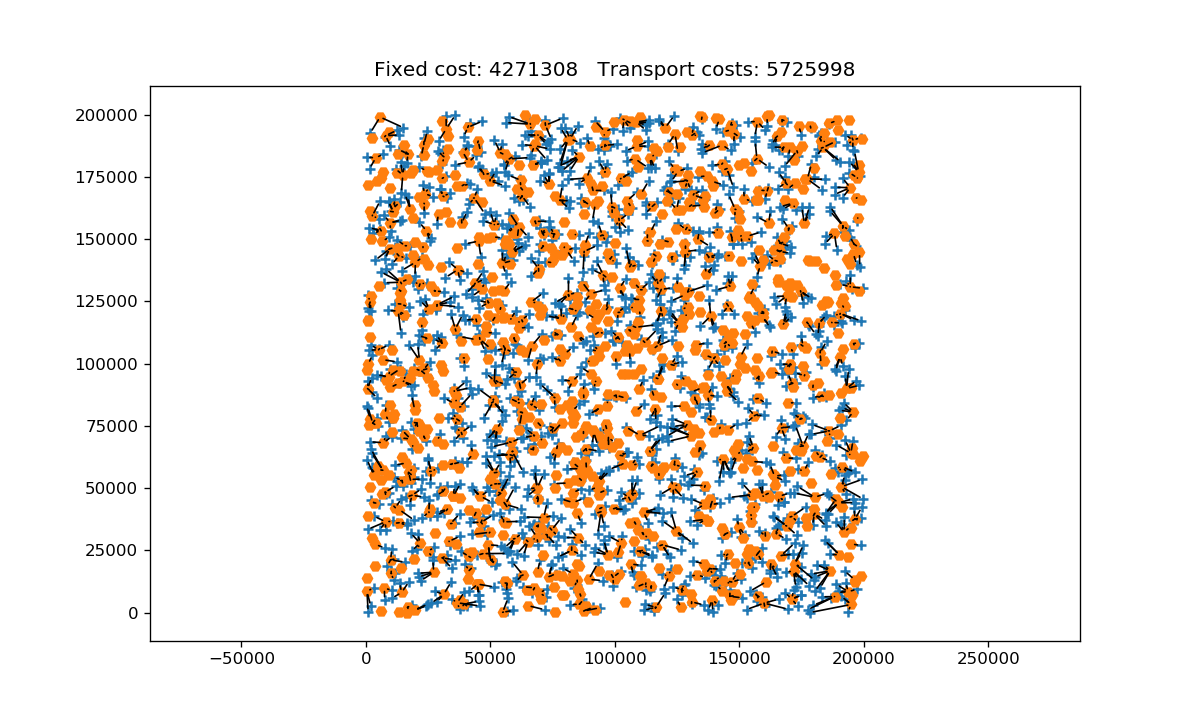

In [239]:
%matplotlib notebook
visualise_solution(data_dict, lns_results_dict)

In [173]:
data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.